In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy

from sklearn.neighbors import KNeighborsClassifier

from tqdm import tqdm

In [8]:

fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

value_to_predict = 'Sex'
# value_to_predict = 'population'

result_dict = {}

n_featues_dict = {
    'BRAIN0': {
        'chrXY': 10,
        'chrX': 9,
        'chrY': 80,
        'autosome': 91,
    },
    'BRAIN1': {
        'chrXY': 7,
        'chrX': 5,
        'chrY': 5,
        'autosome': 59,
    },
    'HEART': {
        'chrXY': 9,
        'chrX': 8,
        'chrY': 93,
        'autosome': 82,
    },
    'None': {
        'chrXY': 10,
        'chrX': 10,
        'chrY': 3,
        'autosome': 82,
    }
}


features_shapsumm_threshold = 45

save_results = True
save_features = False


********************
None
xgboost
chrXY
********************
['F' 'M'] [0, 1]


5it [00:02,  2.39it/s]


--------------------
--------------------
mean_auc=0.99366391184573,
mean_accuracy=0.9864773874985973,
mean_f1=0.9860448473282443,
mean_precision=0.9937438905180841,
mean_recall=0.9787878787878788,
--------------------
total_auc=0.9964479056132084,
total_accuracy=0.9865067466266867,
total_f1=0.9862174578866769,
total_precision=0.9938271604938271,
total_recall=0.9787234042553191,
--------------------
********************
None
xgboost
chrX
********************
['F' 'M'] [0, 1]


5it [00:01,  2.74it/s]


--------------------
--------------------
mean_auc=0.9937932550053762,
mean_accuracy=0.9925036471776456,
mean_f1=0.9923422123704295,
mean_precision=0.9970149253731343,
mean_recall=0.987832167832168,
--------------------
total_auc=0.9986466070754123,
total_accuracy=0.992503748125937,
total_f1=0.9923664122137404,
total_precision=0.9969325153374233,
total_recall=0.9878419452887538,
--------------------
********************
None
xgboost
chrY
********************
['F' 'M'] [0, 1]


5it [00:01,  2.53it/s]


--------------------
--------------------
mean_auc=0.992102188088414,
mean_accuracy=0.9879811468970935,
mean_f1=0.9875715648854962,
mean_precision=0.9967741935483871,
mean_recall=0.9787878787878788,
--------------------
total_auc=0.9941727666768584,
total_accuracy=0.9880059970014993,
total_f1=0.9877300613496932,
total_precision=0.9969040247678018,
total_recall=0.9787234042553191,
--------------------
********************
None
xgboost
autosome
********************
['F' 'M'] [0, 1]


5it [00:02,  1.91it/s]


--------------------
--------------------
mean_auc=0.9088460361187634,
mean_accuracy=0.8260689036022892,
mean_f1=0.8251742159519138,
mean_precision=0.8207167319774704,
mean_recall=0.8327272727272726,
--------------------
total_auc=0.9081041707882952,
total_accuracy=0.8260869565217391,
total_f1=0.8253012048192772,
total_precision=0.817910447761194,
total_recall=0.8328267477203647,
--------------------


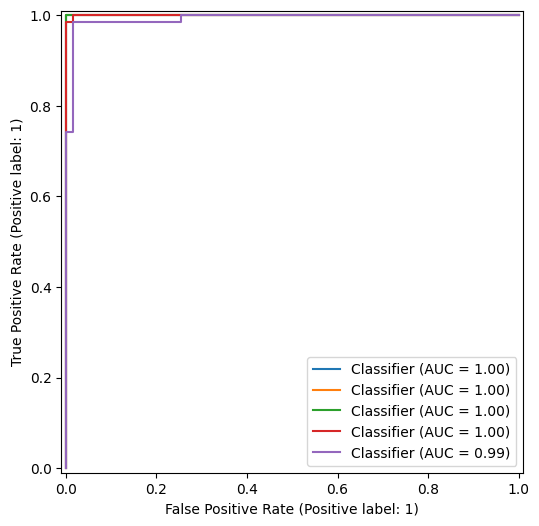

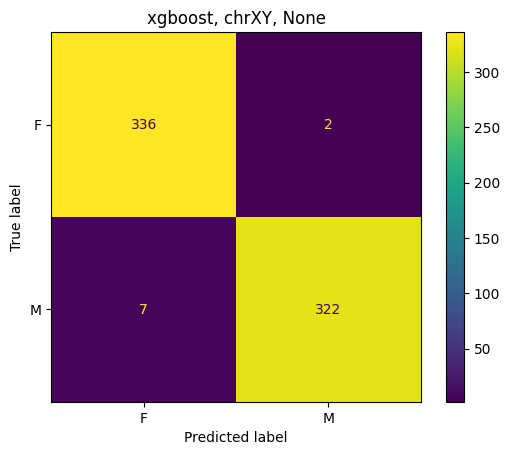

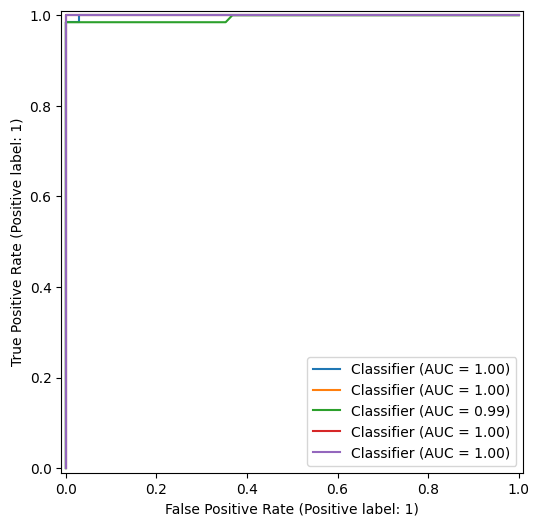

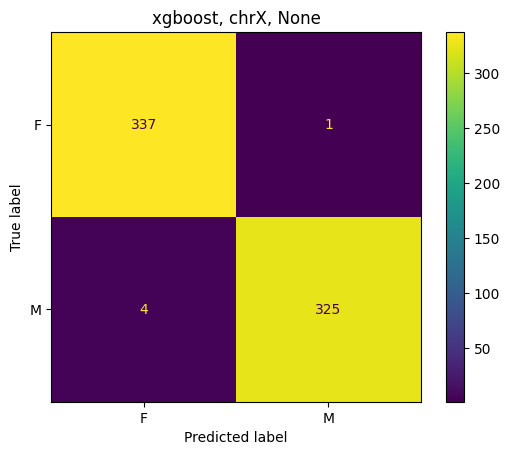

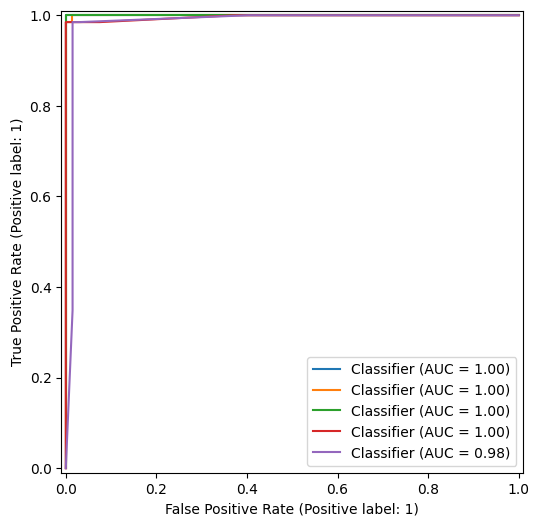

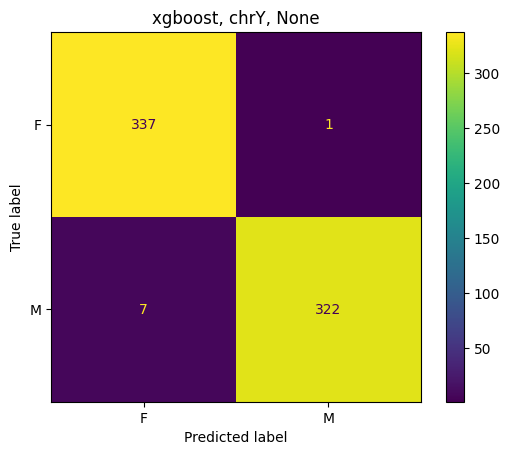

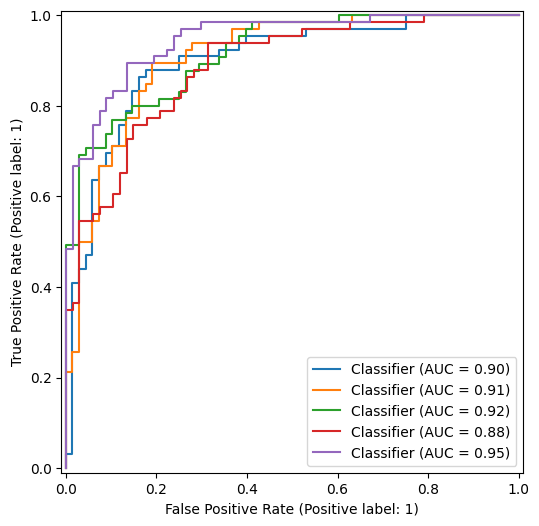

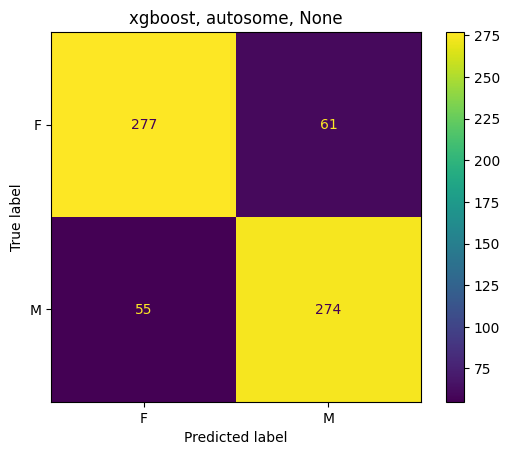

In [37]:
for organ in ['None']:
    result_dict[organ] = {}
    for sex in ['chrXY', 'chrX', 'chrY', 'autosome']:
    # for sex in ['autosome']:

        result_dict[organ][sex] = {}

        print("*" * 20)
        print(organ)
        print(model_type)
        print(sex)
        print("*" * 20)

        # n_features = 0
        n_features = n_featues_dict[organ][sex]

        with open(f'../models/{model_type}.json', 'r') as file:
            model_params = json.load(file)
        model_params = model_params[value_to_predict]

        data = pd.read_hdf(fdir_traintest / f'geuvadis.preprocessed.sex.h5', key=sex)

        features = pd.read_hdf(
            fdir_processed / f'feature_importance.{model_type}.{value_to_predict}.organ_{organ}.h5',
            key=f'{sex}',
        )

        features = features[feature_importance_method]
        features = features.sort_values(ascending=False)

        if n_features != 0:
            features_list = features.iloc[:n_features]
        else:
            features_list = features.loc[features >= features_shapsumm_threshold]
            n_features = len(features_list)
            

        data = data[features_list.index]

        data_header = pd.read_hdf(fdir_processed / 'geuvadis.preprocessed.h5', key='header')

        X = data.values
        y = data_header['Sex']

        label_encoder = LabelEncoder().fit(y)
        print(label_encoder.classes_, "[0, 1]")

        y = label_encoder.transform(y)

        if use_CV:
            cv = StratifiedKFold(n_splits=5)
        else:
            X_train_, X_val, y_train_, y_val = train_test_split(X, y)

        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        accuracies = []
        f1 = []
        precisions = []
        recalls = []
        
        preds = np.zeros(shape=y.shape)
        preds_proba = np.zeros(shape=y.shape)

        fig, ax = plt.subplots(figsize=(6, 6))
        for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
            X_train = X[train]
            y_train = y[train]
            X_test = X[val]
            y_test = y[val]
            
            # train_scaler = StandardScaler().fit(X_train)
            # test_scaler = StandardScaler().fit(X_test)

            train_scaler = RobustScaler().fit(X_train)
            test_scaler = RobustScaler().fit(X_test)

            X_train = train_scaler.transform(X_train)
            X_test = test_scaler.transform(X_test)

            X_train_ = X_train
            y_train_ = y_train
            X_val = X_test
            y_val = y_test


            model = xgb.XGBClassifier(**model_params)
            model.fit(cupy.array(X_train_), y_train_, eval_set=[(X_val, y_val)], verbose=False)


            pred = model.predict(cupy.array(X_test))
            pred_prob = model.predict_proba(cupy.array(X_test))

            preds[val] = pred
            preds_proba[val] = pred_prob[:, 1]

            viz = RocCurveDisplay.from_predictions(
                y_test, pred_prob[:, 1],
                ax=ax,
            )

            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0
            tprs.append(interp_tpr)

            accuracies.append(accuracy_score(y_test, pred))
            f1.append(f1_score(y_test, pred))
            precisions.append(precision_score(y_test, pred))
            recalls.append(recall_score(y_test, pred))

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        mean_accuracy = np.mean(accuracies)
        mean_f1 = np.mean(f1)
        mean_precision = np.mean(precisions)
        mean_recall = np.mean(recalls)

        print("-" * 20)
        print("-" * 20)
        print(f"{mean_auc=},")
        print(f"{mean_accuracy=},")
        print(f"{mean_f1=},")
        print(f"{mean_precision=},")
        print(f"{mean_recall=},")
        print("-" * 20)

        total_auc = roc_auc_score(y, preds_proba)
        total_accuracy = accuracy_score(y, preds)
        total_f1 = f1_score(y, preds)
        total_precision = precision_score(y, preds)
        total_recall = recall_score(y, preds)

        print(f"{total_auc=},")
        print(f"{total_accuracy=},")
        print(f"{total_f1=},")
        print(f"{total_precision=},")
        print(f"{total_recall=},")
        print("-" * 20)

        result_dict[organ][sex]['mean_auc'] = total_auc
        result_dict[organ][sex]['mean_accuracy'] = total_accuracy
        result_dict[organ][sex]['mean_f1'] = total_f1
        result_dict[organ][sex]['mean_precision'] = total_precision
        result_dict[organ][sex]['mean_recall'] = total_recall
        result_dict[organ][sex]['n_features'] = n_features
        
        _ = ConfusionMatrixDisplay.from_predictions(y, preds, display_labels=['F', "M"])
        plt.title(f"{model_type}, {sex}, {organ}")
        
        false_neg = [i for i in range(len(y)) if y[i] == 1 and preds[i] == 0]
        false_pos = [i for i in range(len(y)) if y[i] == 0 and preds[i] == 1]
        
        result_dict[organ][sex]['fp_ids'] = false_pos
        result_dict[organ][sex]['fn_ids'] = false_neg

- [Anonymous 11:59 PM Oct 11] Can we infer what was peculiar about misidentified samples?
- [Tatiana Tatarinova 12:30 AM Yesterday] я бы добавила, что интересно посмотреть, те же самые индивиды неправильно определяются в зависимости от разбиения
- [Anonymous 7:29 PM Yesterday] yes this is very interesting too!


In [43]:
for sex in ['chrXY', 'chrX', 'chrY', 'autosome']:
    print(result_dict['None'][sex]['fn_ids'])
    # result_dict['None'][sex]['fn_ids']

[195, 409, 544, 603, 607, 648, 664]
[31, 57, 314, 512]
[195, 409, 544, 603, 607, 648, 664]
[19, 24, 73, 80, 90, 93, 105, 110, 140, 159, 165, 195, 210, 212, 239, 258, 267, 282, 300, 317, 319, 331, 334, 346, 349, 360, 366, 368, 384, 388, 408, 419, 437, 444, 462, 467, 469, 493, 510, 512, 514, 517, 523, 557, 566, 609, 619, 625, 630, 645, 648, 649, 653, 659, 663]


In [47]:
from supervenn import supervenn
from upsetplot import from_memberships, plot

test_dict = {}
for sex in ['chrXY', 'chrX', 'chrY', 'autosome']:
    test_dict[sex] = set(result_dict['None'][sex]['fn_ids'])

['chrX' 'autosome'] : 
{512}
Index(['ERR188169'], dtype='object')
['autosome'] : 
{384, 258, 514, 388, 517, 645, 649, 267, 523, 140, 653, 19, 659, 663, 24, 408, 282, 159, 419, 165, 300, 557, 437, 566, 444, 317, 319, 73, 331, 334, 462, 80, 210, 467, 212, 469, 90, 346, 93, 349, 609, 360, 105, 619, 493, 110, 366, 368, 625, 239, 630, 510}
Index(['ERR188239', 'ERR188467', 'ERR188171', 'ERR188320', 'ERR188252',
       'ERR188350', 'ERR188354', 'ERR204889', 'ERR188335', 'ERR188041',
       'ERR188437', 'ERR188272', 'ERR204937', 'ERR205020', 'ERR188355',
       'ERR204987', 'ERR188140', 'ERR188293', 'ERR188157', 'ERR188377',
       'ERR188391', 'ERR188173', 'ERR188408', 'ERR188260', 'ERR204829',
       'ERR204977', 'ERR204979', 'ERR188365', 'ERR188149', 'ERR188230',
       'ERR188081', 'ERR204863', 'ERR188382', 'ERR188164', 'ERR188462',
       'ERR188166', 'ERR204951', 'ERR188397', 'ERR188034', 'ERR188400',
       'ERR188346', 'ERR204902', 'ERR188201', 'ERR204850', 'ERR204915',
       'ERR1882

/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origin

Text(0.5, 1.0, 'autosomes')

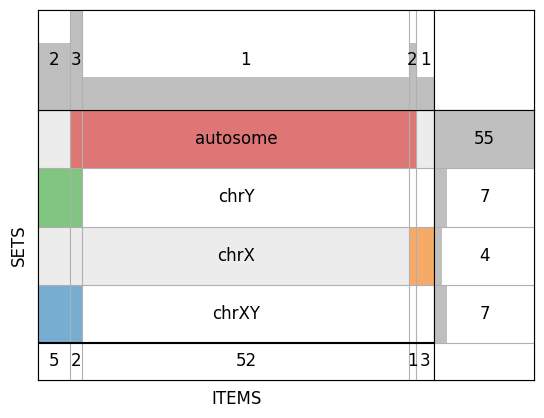

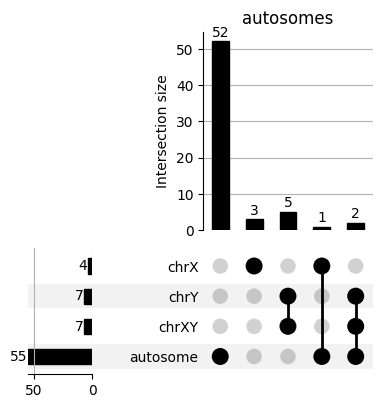

In [56]:

# plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        # sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps',
        # side_plots=False
        )
# plt.title(sex)
# plt.tight_layout()
# g.axes['main'].set_xlabel('# transcripts')
# g.axes['main'].set_ylabel('transcripts set')

membership = []
memb_data = []

for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])

    print(data_header.index[list(g.chunks[el])])

    membership.append((np.array(list(test_dict.keys()))[list(el)]).tolist())
    memb_data.append(len(g.chunks[el]))
    

chr_names = {
    'chrXY': "chr_aXY" , 
    'chrX': "chr_aX" , 
    'chrY': "chr_aY" , 
    'autosome': "autosomes" 
}

example = from_memberships(membership, data=memb_data)
plot(example, show_counts=True)
plt.title(chr_names[sex])

Index(['ERR188021', 'ERR188022', 'ERR188023', 'ERR188024', 'ERR188025',
       'ERR188026', 'ERR188104', 'ERR188105', 'ERR188106', 'ERR188107',
       ...
       'ERR204856', 'ERR204857', 'ERR204937', 'ERR204938', 'ERR204939',
       'ERR204940', 'ERR205020', 'ERR205021', 'ERR205022', 'ERR205023'],
      dtype='object', length=667)